In [1]:
import os
import shutil
import glob
import torch
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import slideio
# from openslide import open_slide
# from openslide.deepzoom import DeepZoomGenerator
from PIL import Image
from torchvision import transforms
import cv2
import random
import time
import argparse
import pdb
import h5py

### Set paths

In [ ]:
# Folder containing all ".svs" files
path_svs = "/mnt/hd1/ani/Liver_pathology_project/Raw_data/Raw_data/"

# Folder where CLAM results will be saved
path_clam = "/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/"

# Folder where we want to save extracted regions 
path_saved_regions = "/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Portal_tract_detection/"

### Use CLAM library to perform contour-based patching

In [3]:
# os.chdir(r"/Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/CLAM-master/")
# # print(os.getcwd())

### First, just do segmentation to optimize mask
!python create_patches_fp.py --source /mnt/hd1/ani/Liver_pathology_project/Raw_data/Raw_data_CLAM_test/ --save_dir /mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/ --patch_size 4096 --step_size 4096 --patch_level 0 --seg

# ### Final run
# !python create_patches_fp.py --source /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Raw_data/Anh_slides_converted_svs_test/ --save_dir /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/ --patch_size 4096 --step_size 4096 --patch_level 0 --seg --patch --stitch

source:  /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Raw_data/Anh_slides_converted_svs_test/
patch_save_dir:  /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/patches
mask_save_dir:  /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/masks
stitch_save_dir:  /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/stitches
source : /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Raw_data/Anh_slides_converted_svs_test/
save_dir : /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/
patch_save_dir : /Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/CLAM_patching/patches
mask_save_dir : /Users/anirudhgang

### Saving extracted 4096x4096 regions

In [6]:
file_path = "104.h5"

with h5py.File(file_path, 'r') as hdf:
    ls = list(hdf.keys())
    # print('List of datasets in this file: \n', ls)
    data = hdf.get(ls[0])   # get dataset --> top left corner coordinates for each patch
    data_np = np.array(data)
    print("Number of patches extracted: ", data_np.shape[0])
    # print('Shape of the data: \n', data_np.shape)
    # print(data_np)

Number of patches extracted:  68


### Lets extract the respective patches from the top=left coordinates and patch size

In [7]:
def eval_transforms():
	eval_t = transforms.Compose([transforms.ToTensor()])
	return eval_t

Slide dimensions:  (59759, 62361)
No. of levels:  4


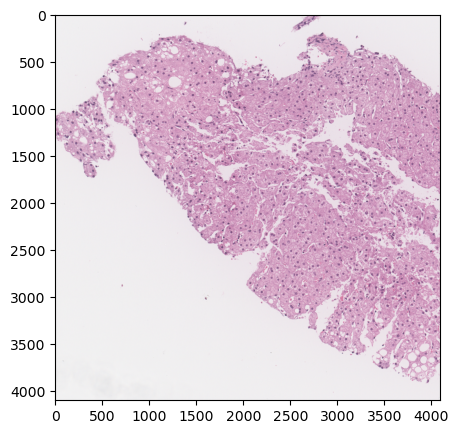

In [10]:
slide = open_slide('/Users/anirudhgangadhar/My_Desktop/UHN_Postdoc/Liver_pathology_project/Raw_data/SVS/104.svs')
slide_dims = slide.dimensions   # (width, height) of original WSI image
n_levels = slide.level_count  # no. of levels in the WSI image
print("Slide dimensions: ", slide_dims)
print("No. of levels: ", n_levels)

ind = int(np.random.randint(0, data_np.shape[0], 1))
# ind = 1
region = slide.read_region((data_np[ind,0], data_np[ind,1]), level=0, size=(4096, 4096))
region = region.convert('RGB')   # converting MxNx4 (RGBA) --> MxNx3 (RGB format)
region = eval_transforms()(region).unsqueeze(dim=0)[0]
# print(region.shape)
# print(type(region))

region_np = region.permute(2,1,0).numpy()
# region_np = region_np[:, :, ::-1]    # BGR --> RGB; use only if original slide is "czi"
# print(region_np.max())
# len(region_np[region_np == 1.0])

plt.figure(figsize=(5,5))
plt.imshow(region_np);

# if len(region_np[region_np == 1.0])/(region_np.shape[0] * region_np.shape[1]) < 0.001:
#     plt.figure(figsize=(5,5))
#     plt.imshow(region_np);